> 基于规则的笔记。

In [56]:
%pylab inline
import pandas as pd
import datetime as dt
from sklearn import svm

Populating the interactive namespace from numpy and matplotlib


In [28]:
udf = pd.read_csv('../data/2nd/tianchi_mobile_recommend_train_user_filtered.csv', index_col=['user_id', 'item_id'])
u = udf.reset_index()

In [4]:
def f1(pred, ref):
    """ Evaluate the F1 value of the prediction set and reference set.
    :param pred: the prediction set.
    :param ref:  the reference set.
    :return: the F1 value.
    """
    pred_len = float(len(pred))
    ref_len = float(len(ref))
    intersected_len = len(pred.intersection(ref))
    precision = intersected_len / pred_len
    recall = intersected_len / ref_len
    print "Hits:", intersected_len
    print "Precision:", precision
    print "Recall:", recall
    return 2 * precision * recall / float(precision + recall)

## 加入收藏隔天购买

In [3]:
ref = set(u[(u.date == '2014-12-17') & (u.behavior_type == 4)].index)
pred = set(u[(u.date == '2014-12-16') & (u.hour >= 17) & ((u.behavior_type == 3) | (u.behavior_type == 3))].index)
f1(pred, ref)

Hits: 26
Precision: 0.0491493383743
Recall: 0.0663265306122


0.05646036916395222

In [6]:
print '总购买量：', len(u[(u.date == '2014-12-17') & (u.behavior_type == 4)])

总购买量： 432


## 近期平均转化率

In [5]:
def item_conversion_recent(df, behavior1, behavior2, date, days=1):
    """
    隔天行为转化的条件概率（转化率）。所用算式：intersection(behavior1, behavior2) / behavior1 。
    :param df: 数据集
    :param date: 给定的日期
    :param behavior1: 给定日期前一天行为
    :param behavior2: 给定日期的行为
    :param days: 相隔天数
    :return: 转化率的系列
    :rtype: pd.Series
    """
    prev_date = (dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(days)).strftime('%Y-%m-%d')
    items_users1 = df[(df.date == prev_date) & (df.behavior_type == behavior1)].groupby(['item_id', 'user_id']).size()
    items_users2 = df[(df.date == date) & (df.behavior_type == behavior2)].groupby(['item_id', 'user_id']).size()
    set1 = set(items_users1.index)
    set2 = set(items_users2.index)
    inter_set = set1.intersection(set2)
    items1 = items_users1[items_users1.index.isin(inter_set)].groupby(level=0).sum()
    items2 = items_users1.groupby(level=0).sum()
    return (items1 / items2).fillna(0)


def item_conversion_recent_avg(df, behavior1, behavior2, date, days=1, avg=3):
    def recent_df(df, date):
        prev_date = (dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(days)).strftime('%Y-%m-%d')
        items_users1 = df[(df.date == prev_date) & (df.behavior_type == behavior1)].groupby(
            ['item_id', 'user_id']).size()
        items_users2 = df[(df.date == date) & (df.behavior_type == behavior2)].groupby(['item_id', 'user_id']).size()
        set1 = set(items_users1.index)
        set2 = set(items_users2.index)
        inter_set = set1.intersection(set2)
        items1 = items_users1[items_users1.index.isin(inter_set)].groupby(level=0).sum()
        items2 = items_users1.groupby(level=0).sum()
        return items1, items2
    tmp1 = []
    tmp2 = []
    for d in [(dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(i)).strftime('%Y-%m-%d') for i in xrange(avg)]:
        t = recent_df(df.reset_index(), d)
        tmp1.append(t[0])
        tmp2.append(t[1])
    sum1 = reduce(lambda a, b: a.add(b, fill_value=0), tmp1)
    sum2 = reduce(lambda a, b: a.add(b, fill_value=0), tmp2)
    return sum1.fillna(0).div(sum2.fillna(1), fill_value=0)

大于 0 的项目数： 175


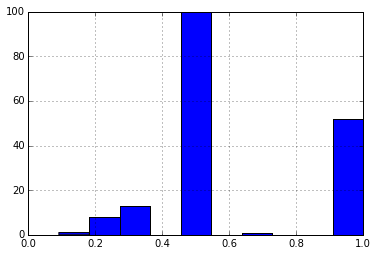

In [18]:
tdf = item_conversion_recent_avg(u, 3, 4, '2014-12-18', avg=5)
tdf[tdf > 0].hist(bins=10)
print '大于 0 的项目数：', len(tdf[tdf > 0])

大于 0 的项目数： 175


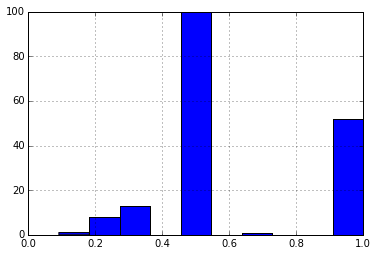

In [23]:
tdf = item_conversion_recent_avg(u, 3, 4, '2014-12-18', avg=5)
tdf[tdf > 0].hist(bins=10)
print '大于 0 的项目数：', len(tdf[tdf > 0])

## 全局转化率

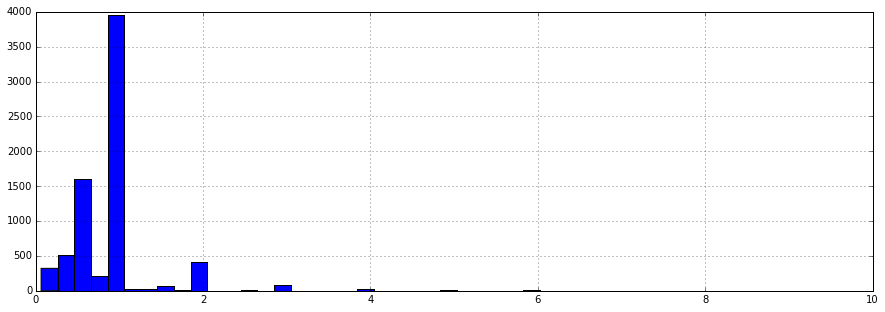

In [31]:
tdf = u[u.behavior_type==4].groupby('item_id').size() / u[u.behavior_type==3].groupby('item_id').size()
tdf.hist(bins=50, figsize=(15, 5));